<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet'])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vaggelisarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Configs: (category_name, review_config, meta_config)
datasets_info = [
    ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    # ("Books", "raw_review_Books", "raw_meta_Books"),
    # ("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    # ("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    # ("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]
    
for category, review_config, metadata_config in datasets_info:
    # Load reviews and metadata
    reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", review_config, trust_remote_code=True)["full"].to_pandas()
    metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", metadata_config, split="full", trust_remote_code=True).to_pandas()

Loading dataset: All_Beauty


In [9]:
!pip install contractions

In [11]:
import pandas as pd
import re
import string
import contractions

from datasets import load_dataset

# Emoticon dictionary for replacements
emoticons = {
    ":)": "happy",
    ":-)": "happy",
    ":(": "sad",
    ":-(": "sad",
    ":D": "happy",
    ":-D": "happy",
    ";)": "wink",
    ";-)": "wink"
}

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"\S+@\S+", '', text)  # remove emails
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"\d+", '', text)  # remove numbers
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2

    text = text.strip()
    return text

# Load and clean each dataset
for category_name, review_config, meta_config in datasets_info:
    print(f"Processing: {category_name}")
    
    # Drop rows with missing values in critical fields
    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])

    # Clean text fields
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit='ms')

	# Merge with metadata
    df = pd.merge(reviews, metadata, how="left", on="parent_asin", suffixes=("", "_meta"))

    # Save cleaned dataset
    cleaned_category_name = category_name.replace(".csv", "_cleaned.csv")
    df.to_csv(cleaned_category_name, index=False)
    print(f"Saved cleaned data to {cleaned_category_name}")


Processing: All_Beauty
Saved cleaned data to All_Beauty


In [12]:
!pip install matplotlib seaborn wordcloud

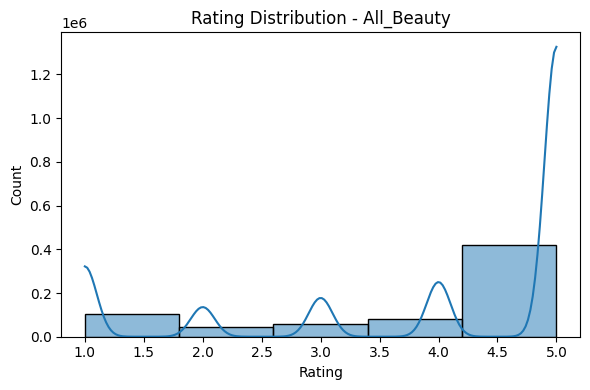

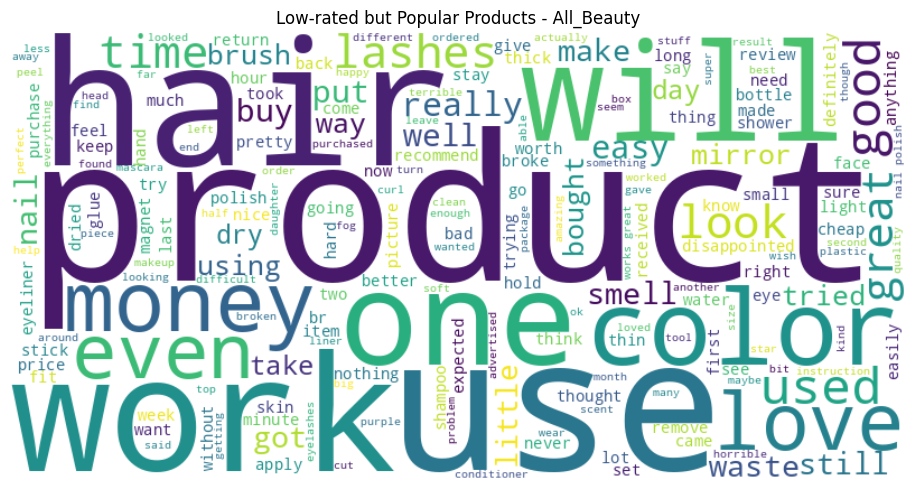


Top 5 Best-Selling Products in All_Beauty:

Title: Salux Nylon Japanese Beauty Skin Bath Wash Cloth/towel (3) Blue Yellow and Pink
ASIN: B085BB7B1M
Store: SALUX
Features: ['Lekki materiał nylonowy wysycha szybko i w pełni nadaje się do prania w pralce, więcej sanitarnych niż Luffa'
 'Tworzy grubą pianę, a jednocześnie pobudza skórę i krążenie krwi, idealny do masażu cellulitu'
 'Idealnie nadaje się do stosowania na pokazach lub do mycia artykułów ogólnie']
Avg Rating: 4.62
Total Reviews: 1962
------------------------------------------------------------
Title: Godefroy Tint Kit for Spot Coloring, Dark Brown
ASIN: B0BM4GX6TT
Store: Godefroy
Features: ['20 application kit can be used on beards, mustaches, side burns, temples, anywhere you need a little color.'
 'Root touch up to cover gray hair.'
 'Complete kit. Everything you need included to get started.'
 '20 Single application pre-measured capsules covers the most resistant gray hair.'
 'Cream formula (no drip) for easy application. 

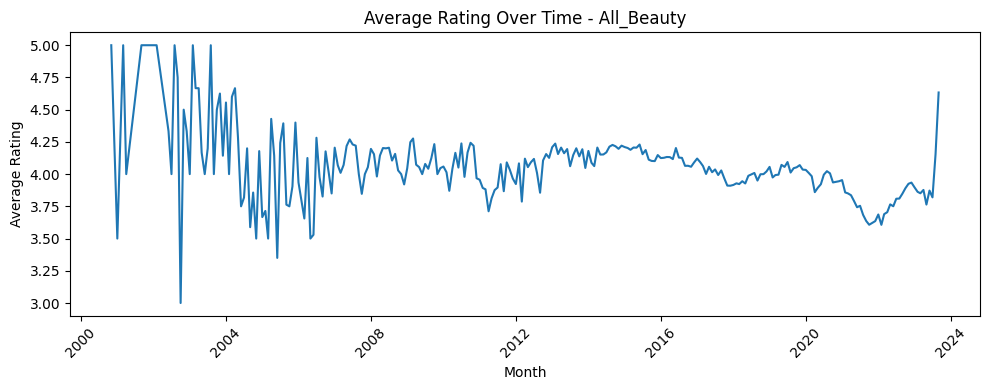

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

for category_name, review_config, meta_config in datasets_info:
 	# --- Distribution of Ratings ---
    plt.figure(figsize=(6, 4))
    sns.histplot(df["rating"], bins=5, kde=True)
    plt.title(f"Rating Distribution - {category_name}")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Low-rated Popular Products ---
    product_stats = df.groupby("parent_asin").agg(
        avg_rating=("rating", "mean"),
        review_count=("rating", "count")
    ).reset_index()

    bad_products = product_stats[(product_stats["review_count"] > 50) & (product_stats["avg_rating"] < 3.0)]
    bad_reviews = df[df["parent_asin"].isin(bad_products["parent_asin"])]
    wordcloud_text = " ".join(bad_reviews["cleaned_text"].dropna())

    if wordcloud_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(wordcloud_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Low-rated but Popular Products - {category_name}")
        plt.tight_layout()
        plt.show()

    # --- Top 5 Best-Selling Products ---
    top5_asins = df["parent_asin"].value_counts().head(5).index
    print(f"\nTop 5 Best-Selling Products in {category_name}:\n")
    for asin in top5_asins:
        item = df[df["parent_asin"] == asin].iloc[0]
        print(f"Title: {item.get('title_meta', 'N/A')}")
        print(f"ASIN: {asin}")
        print(f"Store: {item.get('store', 'Unknown')}")
        print(f"Features: {item.get('features', [])}")
        print(f"Avg Rating: {df[df['parent_asin'] == asin]['rating'].mean():.2f}")
        print(f"Total Reviews: {len(df[df['parent_asin'] == asin])}")
        print("-" * 60)

	
    # --- Rating Trends Over Time ---
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()
    trend = df.groupby("month")["rating"].mean().reset_index()
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trend, x="month", y="rating")
    plt.xticks(rotation=45)
    plt.title(f"Average Rating Over Time - {category_name}")
    plt.xlabel("Month")
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.show()